#  eCommerce purchase prediction

Importing packages

In [53]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from easygui import fileopenbox

In [54]:
#Let us load the Retail Rocket CSV files into DataFrames
E=fileopenbox()

In [55]:
C=fileopenbox()

In [56]:
I_one=fileopenbox()

In [57]:
I_two=fileopenbox()

In [58]:
Events=pd.read_csv(E)

In [59]:
Category=pd.read_csv(C)

In [60]:
Item_properties_1=pd.read_csv(I_one)

In [61]:
Item_properties_2=pd.read_csv(I_two)

In [62]:
#Let's take a peek at the Events dataframe
Events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [63]:
Events['timestamp']=pd.to_datetime(Events['timestamp'])

In [64]:
Events

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1970-01-01 00:23:58.398785939,591435,view,261427,NaN
2756097,1970-01-01 00:23:58.399813142,762376,view,115946,NaN
2756098,1970-01-01 00:23:58.397820527,1251746,view,78144,NaN
2756099,1970-01-01 00:23:58.398530703,1184451,view,283392,NaN


In [65]:
#The timestamp portionis in Unix Epoch format e.g. 1433221332117 will be converted to Tuesday, 2 June 2015 5:02:12.117 AM GMT
#Visitor Id is the unique user currently browsing the website
#Event is what the user is currently doing in that current timestamp
#Transaction ID will only have value if the user made a purchase as shown below

In [66]:
#Which event has a value in its transaction id
Events[Events.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [67]:
#The rest of the events with NaN transaction ids are either view or add to cart

Now let's take a look at the Item Properties

In [72]:
Events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN


In [73]:
Category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [74]:
#Category IDs explain the relationship of different products with each other

In [75]:
Category.categoryid.value_counts()

1697    1
1274    1
1120    1
1122    1
1124    1
       ..
577     1
579     1
581     1
583     1
0       1
Name: categoryid, Length: 1669, dtype: int64

In [76]:
Item_properties_1.loc[(Item_properties_1.property == 'categoryid') & (Item_properties_1.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
6363096,1431226800000,339403,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
7942027,1431226800000,418837,categoryid,1016
10230975,1431226800000,85538,categoryid,1016
7280176,1431226800000,278463,categoryid,1016


In [77]:
#Customer behaviour exploration

WE will  start separating customers into two categories, those who purchased something and those who didn't

In [78]:
customer_purchased=Events[Events.transactionid.notnull()].visitorid.unique()

In [79]:
customer_purchased.size


11719

1. Since we have no information whether there were any repeat users who bought something from the site, I'll just have to assume for now that the 11,719 visitors are unique and made at least a single purchase

#Let's get all unique visitor ids as well
All_customers=Events.visitorid.unique()
All_customers.size


In [80]:
#Out of 1,407,580 unique visitor ids, let's take out the ones that did  bought something
customer_browsed=[x for x in All_customers if x not in customer_purchased]

In [81]:
len(customer_browsed)
#Since it is in list..

1395861

So there are 1395861 unique site visitors who didn't buy anything,again assuming that there were no repeat users with different visitor IDs

In [82]:
#WE can also do it in numpy
temp_array=np.isin(customer_browsed,customer_purchased)
temp_array[temp_array==False].size

1395861

In [83]:
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787], dtype=int64)

In [113]:
pd.set_option('display.max_rows',50)

In [114]:
Events

,timestamp,visitorid,event,itemid,transactionid
0,1970-01-01 00:23:53.221332117,257597,view,355908,NaN
1,1970-01-01 00:23:53.224214164,992329,view,248676,NaN
2,1970-01-01 00:23:53.221999827,111016,view,318965,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN
4,1970-01-01 00:23:53.221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1970-01-01 00:23:58.398785939,591435,view,261427,NaN
2756097,1970-01-01 00:23:58.399813142,762376,view,115946,NaN
2756098,1970-01-01 00:23:58.397820527,1251746,view,78144,NaN
2756099,1970-01-01 00:23:58.398530703,1184451,view,283392,NaN


In [96]:
Events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

In [107]:
Events.visitorid.value_counts

<bound method IndexOpsMixin.value_counts of 0           257597
1           992329
2           111016
3           483717
4           951259
            ...   
2756096     591435
2756097     762376
2756098    1251746
2756099    1184451
2756100     199536
Name: visitorid, Length: 2756101, dtype: int64>

Below is a snapshot of visitor id 102019 and their buying journey from viewing to transaction (purchase)

In [118]:
Events[Events.visitorid==483717].sort_values('timestamp')
#So this visitorid_483717 has only viewed it

,timestamp,visitorid,event,itemid,transactionid
8048,1970-01-01 00:23:53.221804507,483717,view,253185,NaN
16809,1970-01-01 00:23:53.221871581,483717,view,353936,NaN
3,1970-01-01 00:23:53.221955914,483717,view,253185,NaN


What insights can we offer the visitor to guide them in their buying journey?

In [119]:
customer_purchased = Events[Events.transactionid.notnull()].visitorid.unique()

In [122]:
customer_purchased

array([ 599528,  121688,  552148, ..., 1155978, 1050575,  855941],
      dtype=int64)

In [125]:
purchased_items = []
# Create another list that contains all their purchases 
for i in customer_purchased:
    purchased_items.append(list(Events.loc[(Events.visitorid==i)& (Events.transactionid.notnull())].itemid.values))

In [126]:
purchased_items


[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044],
 [54058,
  284871,
  251130,
  268335,
  183049,
  261940,
  369093,
  370745,
  192990,
  277119,
  241716,
  283766,
  16417,
  217068,
  36372,
  68923,
  428015,
  69533,
  13520,
  385638,
  442871,
  136526,
  247862,
  93828,
  230911,
  382595,
  34853,
  216260,
  154812,
  445241,
  57702,
  347850,
  151855,
  226327,
  288525,
  51354,
  345994,
  170438,
  254301,
  266439,
  193718,
  388558,
  26745,
  184086,
  79956,
  252040,
  82232,
  309821,
  394518,
  462070,
  331980,
  353111,
  200527,
  235933,
  68532,
  358882,
  60012,
  29741,
  270487,
  163689,
  6913,
  156457,
  341578,
  163352,
  234493,
  135174,
  452481,
  241755,
  56323,
  210137,
  184397,
  285202,
  198690,
  195958,
  239210,
  71640,
  189108,
  369112,
  346186,
  211207,
  134330,
  257070,
  302239,
  459480,
  57577,
  1952

In [127]:

# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

So now we can present to the visitor a list of the other items a customer previously
bought along with what item the current visitor is viewing e.g. item number 302422

In [136]:
recommender_bought_bought(80582,purchased_items)

[105792, 200793, 12836, 380775, 15335, 400969, 25353, 302422, 237753, 317178]

In [140]:
#That was a very crude way of recommending other items to the visitor

What other insights can we gather from the items that were viewed, added to cart and sold?¶

In [152]:
Events['event'].value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [151]:
Events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid'], dtype='object')

In [145]:
All_visitors=Events.visitorid.sort_values().unique()

In [147]:
All_visitors.size

1407580

In [153]:
#Buying visitors
Buying_visitors=Events[Events.event=='transaction'].visitorid.sort_values().unique()

In [154]:
Buying_visitors.size

11719

Out of 1407580 visitors, only  11719  bought goods where as 13,95,861 only view the product 
so 0.8% people  is the purcahse rate where as 99.16%  is the non-Purchase rate

In [157]:
viewing_visitors_list = list(set(All_visitors) - set(Buying_visitors))

In [160]:
len(viewing_visitors_list)

1395861

In [166]:
 def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = Events[Events.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])


In [169]:
Buying_visitors

array([    172,     186,     264, ..., 1407070, 1407110, 1407398],
      dtype=int64)

In [167]:
buying_visitors_df=create_dataframe(Buying_visitors)

In [168]:
buying_visitors_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1
3,419,3,4,1,1
4,539,1,4,1,1
...,...,...,...,...,...
11714,1406787,3,20,1,1
11715,1406981,4,4,1,1
11716,1407070,1,1,1,1
11717,1407110,2,7,1,1


In [190]:
buying_visitors_df.columns

Index(['visitorid', 'num_items_viewed', 'view_count', 'bought_count',
       'purchased'],
      dtype='object')

In [199]:
len(viewing_visitors_list)

1395861

In [203]:
1395861-11719 

1384142

In [204]:
1384142*0.7

968899.3999999999

In [180]:
#Let's shuffle the viewing visitors list for randomness
import random
random.shuffle(viewing_visitors_list)

In [205]:
viewing_visitors_list

[625625,
 643086,
 999224,
 935665,
 864552,
 1018191,
 120058,
 649073,
 125265,
 88525,
 1137116,
 156351,
 288148,
 690784,
 1213501,
 658042,
 9842,
 448576,
 478717,
 572674,
 205166,
 10632,
 219078,
 513562,
 1000910,
 27531,
 913130,
 1267076,
 780103,
 1268480,
 333616,
 340919,
 355760,
 278224,
 1289708,
 1007318,
 76320,
 573656,
 323502,
 1064031,
 600968,
 1212376,
 1055706,
 1381455,
 1107673,
 450508,
 1315421,
 279109,
 1069211,
 1282440,
 945718,
 1401872,
 445864,
 362121,
 868726,
 1061602,
 193091,
 1050843,
 1030191,
 572084,
 1406919,
 1097867,
 874027,
 774660,
 1157247,
 866609,
 379673,
 469285,
 361236,
 1057242,
 962476,
 540290,
 1217628,
 23577,
 64738,
 405267,
 277158,
 1297320,
 151517,
 681265,
 201162,
 950878,
 797715,
 430876,
 411032,
 716506,
 245720,
 1348059,
 539574,
 136288,
 836293,
 913126,
 1149084,
 384563,
 954938,
 535321,
 1201366,
 1146439,
 1005955,
 806687,
 1233531,
 1311737,
 604228,
 1124945,
 136701,
 566386,
 1139091,
 431642,
 

In [207]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27820])

In [210]:
viewing_visitors_df.shape

(27820, 5)

In [211]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [213]:
#Let's shuffle main_df first
main_df = main_df.sample(frac=1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


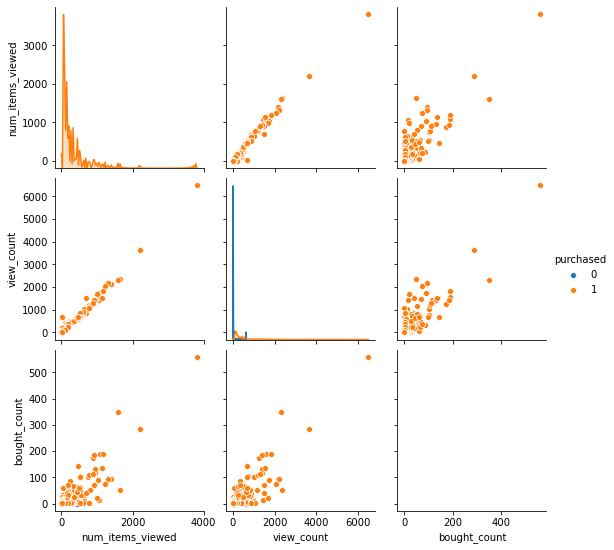

In [214]:
sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],
             y_vars = ['num_items_viewed', 'view_count', 'bought_count'],  hue = 'purchased')

The plot above clearly indicates that the higher the view count, the higher the chances of that visitor buying something. Duh!

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [216]:
main_df

,visitorid,num_items_viewed,view_count,bought_count,purchased
23168,291587,2,2,0,0
15928,518734,1,1,0,0
16468,802872,1,1,0,0
9775,1174875,1,2,1,1
16296,328966,1,1,0,0
...,...,...,...,...,...
31469,32805,1,1,0,0
26798,320291,1,1,0,0
19492,1305889,2,3,0,0
24141,1192747,1,1,0,0


In [261]:
main_df.dtypes

visitorid           int64
num_items_viewed    int64
view_count          int64
bought_count        int64
purchased           int64
dtype: object

In [258]:
x=main_df.iloc[:,:4]
x

,visitorid,num_items_viewed,view_count,bought_count
23168,291587,2,2,0
15928,518734,1,1,0
16468,802872,1,1,0
9775,1174875,1,2,1
16296,328966,1,1,0
...,...,...,...,...
31469,32805,1,1,0
26798,320291,1,1,0
19492,1305889,2,3,0
24141,1192747,1,1,0


In [259]:
y=main_df['purchased']
y_df=pd.DataFrame(y)

In [260]:
y_df['purchased'].value_counts()/y_df.shape[0]
#70-30 More likely balanced data

0    0.703609
1    0.296391
Name: purchased, dtype: float64

In [276]:
X_train, X_test, y_train, y_test = train_test_split(main_df, y_df, random_state = 42, train_size = 0.7)

In [268]:
model=[]
model.append(('LR',LogisticRegression()))
model.append(('LDA',LinearDiscriminantAnalysis()))
model.append(('DT',DecisionTreeClassifier()))
model.append(('RF',RandomForestClassifier()))
model.append(('NB',GaussianNB()))
model.append(('SVC',SVC()))
model.append(('KNN',KNeighborsClassifier()))
model.append(('XGB',XGBClassifier()))

In [269]:
import warnings
warnings.filterwarnings('ignore')

In [270]:
seed=7
results=[]
names=[]
scoring='accuracy'
for name,models in model:
    kfold=KFold(n_splits=5,random_state=seed)
    cv_results=cross_val_score(models,X_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    final_output=name,cv_results.mean(),cv_results.std()
    print(final_output)

('LR', 0.7807145085660877, 0.10364343833633452)
('LDA', 0.7106985303716236, 0.00483584738031302)
('DT', 1.0, 0.0)
('RF', 1.0, 0.0)
('NB', 0.7170214896272277, 0.0026930938774896657)
('SVC', 0.704845250403371, 0.0028011255225564267)
('KNN', 0.6430969892068863, 0.005239242793598077)
('XGB', 1.0, 0.0)


Text(0.5, 0, "['LR', 'LDA', 'DT', 'RF', 'NB', 'SVC', 'KNN', 'XGB']")

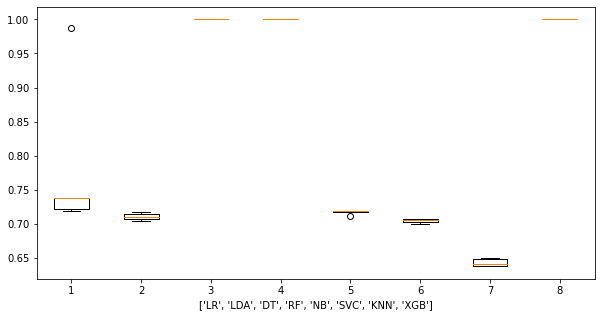

In [271]:
fig=plt.figure(figsize=(10,5))
plt.boxplot(results)
plt.xlabel(names)

In [273]:
model=RandomForestClassifier().fit(X_train,y_train)
predtest=model.predict(X_test)
accuracy_score(y_test,predtest)

1.0

In [274]:
model=RandomForestClassifier().fit(X_train,y_train)
predtrain=model.predict(X_train)
accuracy_score(y_train,predtrain)

1.0

In [284]:
y_test

,purchased
20577,0
24416,0
32792,0
31993,0
615,1
...,...
21221,0
36,1
35423,0
1384,1


In [285]:
predtest

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [290]:
predtest

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [292]:
#plt.scatter(y_test,predtest)

In [288]:
Diff=y_test['purchased']-pred_df[0]

In [289]:
Diff

0        1.0
1        NaN
2        1.0
3        NaN
4        NaN
        ... 
39523    NaN
39524    NaN
39527    NaN
39531    NaN
39537    NaN
Length: 20126, dtype: float64

In [275]:
 #Random forest good accuracy

In [277]:
logreg = LogisticRegression(penalty='l2',
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None)

In [278]:
logreg.fit(X_train,y_train)

LogisticRegression()

In [279]:
y_pred_class = logreg.predict(X_test)

In [280]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.7267


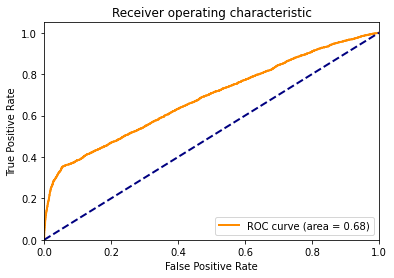

In [282]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")